# Object Detection Using AI-powered Models Based On Deep Learning

## Car Detection using YOLOv8

Install and import necessary libraries

1. `ultralytics` for YOLO (You Only Look Once) model used for vehicle detection.
2. `opencv-python` for image processing
3. `matplotlib` for image display and visualization

In [1]:
# install ultralytics
!pip install ultralytics opencv-python matplotlib --quiet

Here, we import the libraries required for image processing (cv2, PIL, matplotlib), as well as the YOLO model for vehicle detection and the necessary packages for handling images from URLs.

In [17]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
from IPython.display import Image as IPImage, display
import os
import requests
from PIL import Image
from io import BytesIO

## Model Implementation
1. Extracting and Saving Image from URL
- The given URL is taken from https://www.denvergov.org/maps/map/trafficcameras on the camera facing Arapahoe Street and 14th Street

In [87]:
# Extract image from URL
camera_url = "https://dengov-traffic-cameleon.s3.us-west-2.amazonaws.com/we17ne.jpg"

response = requests.get(camera_url)
img = Image.open(BytesIO(response.content))
img.save("traffic_cam_image.jpg")
image_path = "traffic_cam_image.jpg"

2. Vehicle Detection Using YOLOv8x
- We choose the YOLOv8's extralarge version to better detect objects especially those behind polls or blocked by other vehicles in perspective


image 1/1 /Users/quynh/AurariaHack2025/traffic_cam_image.jpg: 384x640 1 person, 8 cars, 1 truck, 204.6ms
Speed: 0.5ms preprocess, 204.6ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


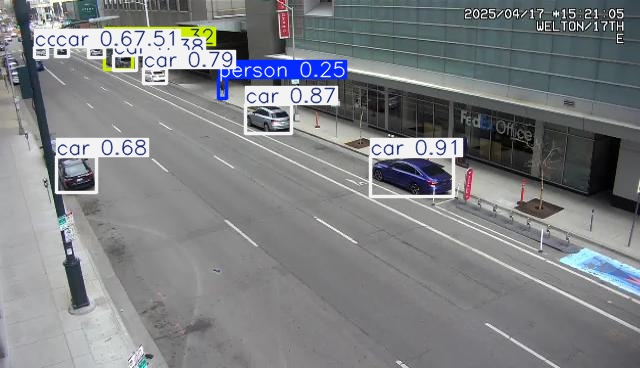

In [90]:
# Using model YOLOv8x to detect vehicles in camera image
model = YOLO('yolov8x.pt')

results = model(image_path)
result = results[0]
result.save(filename='detected.jpg')
display(IPImage(filename='detected.jpg'))

In [91]:
# count the number of vehicles present
num_cars = 0

for result in results:
    for box in result.boxes:
        label = result.names[int(box.cls)]
        if label == 'car' or label == 'truck':
            num_cars += 1
print(f"Number of vehicles detected: {num_cars}")

Number of vehicles detected: 9


## Detect vehicles within a specified area of the image

As seen in the image, there are two meter sections on two sides of the street; 5 parking spaces for the left section and 2 for the other. We want to segment the image into two regions for the YOLOv8 model to detect and count the number of cars.

Suppose the left meters have ID 01, and the right have ID 02, we can scale the image appropriately:

In [144]:
# Read the image using OpenCV and get the image resolution
image = cv2.imread(image_path)
height, width, channel = image.shape

print(f"Image resolution: {width} x {height}")
print(f"Number of color channels: {channel}")

Image resolution: 640 x 368
Number of color channels: 3


In [145]:
# Crop the image into two regions for meter detection
# These cropped images are saved as "meter_01.jpg" and "meter_02.jpg" for further analysis
left_region = image[int(height*0.3):height, 0:int(width*0.3)]
right_region = image[0:int(height*0.7), int(width*0.5):int(width*0.9)]

cv2.imwrite("meter_01.jpg", left_region)
cv2.imwrite("meter_02.jpg", right_region)

# Perform vehicle detection on cropped regions
results_01 = model("meter_01.jpg")[0]
results_02 = model("meter_02.jpg")[0]

annotated_01 = results_01.plot()
annotated_02 = results_02.plot()


image 1/1 /Users/quynh/AurariaHack2025/meter_01.jpg: 640x480 1 car, 770.4ms
Speed: 9.5ms preprocess, 770.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /Users/quynh/AurariaHack2025/meter_02.jpg: 640x640 1 car, 333.6ms
Speed: 1.1ms preprocess, 333.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


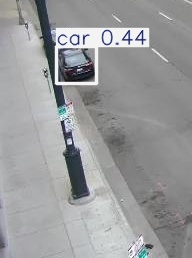

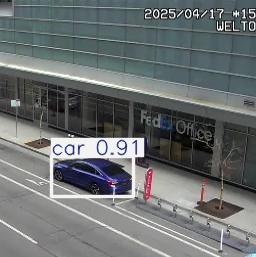

In [97]:
# Save and display annotated images
cv2.imwrite("detected_meter_01.jpg", annotated_01)
cv2.imwrite("detected_meter_02.jpg", annotated_02)

display(IPImage(filename="detected_meter_01.jpg"))
display(IPImage(filename="detected_meter_02.jpg"))

In [99]:
# Count number of cars detected in each region
car_count_01 = sum(1 for box in results_01.boxes if model.names[int(box.cls[0])] == 'car')
car_count_02 = sum(1 for box in results_02.boxes if model.names[int(box.cls[0])] == 'car')

print(f"Meter 01: {car_count_01} car(s) detected")
print(f"Meter 02: {car_count_02} car(s) detected")

Meter ID 01: 1 car(s) detected
Meter ID 02: 1 car(s) detected


## Sidewalk Detection For Detecting Only Parking Cars

The YOLOv8 model did a great job detecting parked vehicles in the image. However, one limitation remains, the model also detects moving vehicles if they happen to be within the detection region, such as cars driving by on the street. This is evident in our results, where some lanes of traffic are visible within the detection area.

To address this, we can incorporate the Segment Anything Model (SAM) to perform image segmentation and color-code detected regions. By doing this, we can:
- Detect and segment the parking meters using SAM.
- Cross-reference YOLO-detected vehicles with the segmented regions of the meters.
- Isolate vehicles next to meters as our targeted parked cars.

Additionally, we can segment sidewalks and use their proximity to vehicles as an indicator of parked status.

In [ ]:
pip install git+https://github.com/facebookresearch/segment-anything.git

In [114]:
import numpy as np
import torch
from segment_anything import sam_model_registry, SamPredictor, SamAutomaticMaskGenerator

In [109]:
# Function to display the segmentation masks
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

### Image Segmentation with SAM

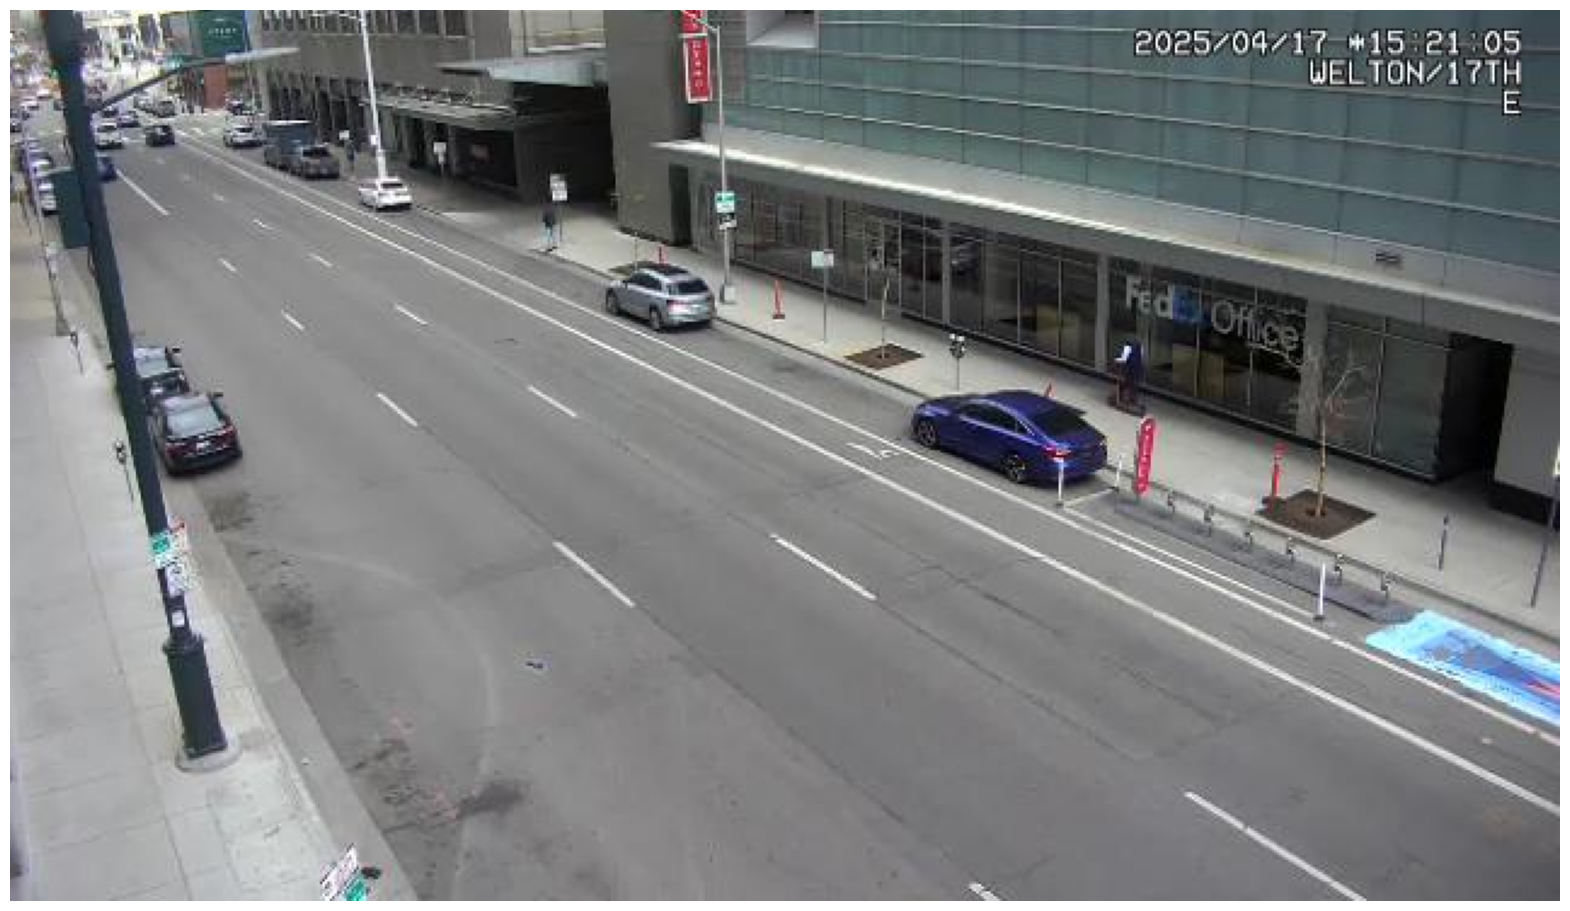

In [123]:
# Load the image
image = cv2.imread('traffic_cam_image.jpg')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Show original image
plt.figure(figsize=(20,20))
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

In [112]:
import sys
sys.path.append("..")

In [142]:
# Load the SAM model and generate masks

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to("cpu")

mask_generator = SamAutomaticMaskGenerator(sam)

In [128]:
masks = mask_generator.generate(image_rgb)

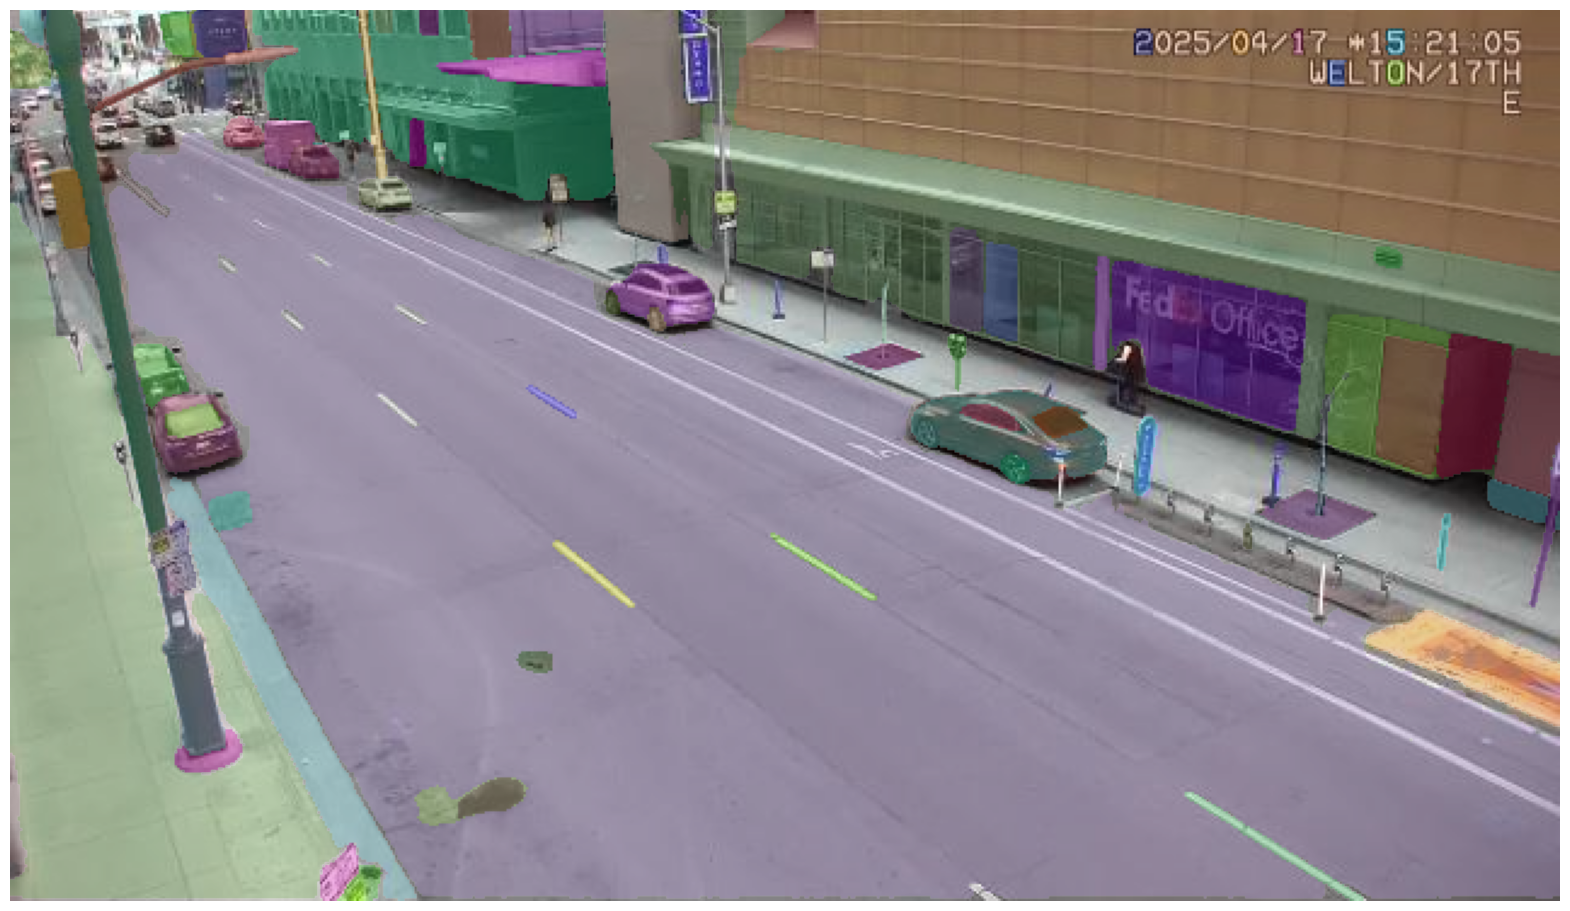

In [147]:
# Display the segmented image with SAM model
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 